In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import time

import notebook_style
labels = notebook_style.labels

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#2D-implicit-heat-transfer-coupled-with-cure-model" data-toc-modified-id="2D-implicit-heat-transfer-coupled-with-cure-model-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>2D implicit heat transfer coupled with cure model</a></span><ul class="toc-item"><li><span><a href="#RTM-Mold-Model" data-toc-modified-id="RTM-Mold-Model-13.1"><span class="toc-item-num">13.1&nbsp;&nbsp;</span>RTM Mold Model</a></span></li><li><span><a href="#Calculate-thermal-composite-properties" data-toc-modified-id="Calculate-thermal-composite-properties-13.2"><span class="toc-item-num">13.2&nbsp;&nbsp;</span>Calculate thermal composite properties</a></span></li><li><span><a href="#Cure-Model" data-toc-modified-id="Cure-Model-13.3"><span class="toc-item-num">13.3&nbsp;&nbsp;</span>Cure Model</a></span></li><li><span><a href="#Discretize-space" data-toc-modified-id="Discretize-space-13.4"><span class="toc-item-num">13.4&nbsp;&nbsp;</span>Discretize space</a></span></li><li><span><a href="#Time-discretization" data-toc-modified-id="Time-discretization-13.5"><span class="toc-item-num">13.5&nbsp;&nbsp;</span>Time discretization</a></span></li><li><span><a href="#Implicit-Model-and-helper-funftions" data-toc-modified-id="Implicit-Model-and-helper-funftions-13.6"><span class="toc-item-num">13.6&nbsp;&nbsp;</span>Implicit Model and helper funftions</a></span></li><li><span><a href="#Simulate!" data-toc-modified-id="Simulate!-13.7"><span class="toc-item-num">13.7&nbsp;&nbsp;</span>Simulate!</a></span></li><li><span><a href="#Postprocessing" data-toc-modified-id="Postprocessing-13.8"><span class="toc-item-num">13.8&nbsp;&nbsp;</span>Postprocessing</a></span></li></ul></li></ul></div>

# 2D implicit heat transfer coupled with cure model

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2020_

    Code under MIT license, all other material under CC-BY-3.0 license
    
Now finally couple the Crank-Nicholson-formulation of the 2d heterogeneous heat transfer [lesson 12](./11%20-%201D%20implicit%20(Crank-Nicholson)%20heat%20transfer%20coupled%20with%20cure%20model.ipynb) and the cure reaction calculation by the Runge-Kutta-4 method. 

## RTM Mold Model

We simulate a quarter of a RTM tool (symmetric in both axis) with two plies with different fiber orientation but the same thickness $d_{ply}$. Left and lower boundary are set to the cure temperature (Dirichlet B.C.) and the right and top boundary have no heat flux (Neumann B.C.). 

<img src="./figures/Modell_full.png" width="600"/>

## Calculate thermal composite properties

In [30]:
import material_data

### Mould material
# thermal steel properties
mould_material = material_data.steel
# use aluminium properties for comparison
# mould_material = material_data.aluminium


### Composite properties
# Fibre volume fraction
phi = .4

# Fibre material (carbon or glass)
fibre_material = material_data.CF
# fibre_material = material_data.GF

# Resin material (thermal properties, cure model selected later)
resin_material = material_data.EP

# Combine to composite material
composite_material = {**fibre_material, **resin_material}

### Calculate required thermal properties
composite_material = material_data.build_comp_material(composite_material, phi=phi)

for key in ["cp", "k_parallel", "k_perp", "psi"]:
    print(f"{key}: \t {composite_material[key]: .3f}")

cp: 	  964.327
k_parallel: 	  4.126
k_perp: 	  0.339
psi: 	  0.505


## Cure Model

In [31]:
import cure_calculation
from cure_models import Hein_2018 as cure_model

## Discretize space

In [32]:
# dh = dx = dy
dh = 1/1000
d_mold = 6/1000
w_mold = 8/1000
d_ply = 4/1000
w_ply = 20/1000

d_tot = d_mold + 2 * d_ply
w_tot = w_mold + w_ply

print(f"physical domain size [mm^2] = {w_tot*1000 :.2f} x {d_tot*1000 :.2f}")

Nx = int(np.ceil((w_tot) / dh))
Ny = int(np.ceil((d_tot) / dh))

print(f"Nx = {Nx}, Ny = {Ny} -> {Nx * Ny} elements")
shape = (Ny, Nx)

# shift coordinates half a step (element not material interface)
x = (np.arange(Nx) + .5) * dh
y = (np.arange(Ny) + .5) * dh  
xx, yy = np.meshgrid(x, y)

# make indexes of materials (boolean arrays)
idx_mold = (xx <= w_mold) | (yy <= d_mold)
idx_comp = (xx > w_mold) & (yy > d_mold)
idx_ply_1 = idx_comp & (yy <= d_mold + d_ply)
idx_ply_2 = idx_comp & (yy > d_mold + d_ply)

print(f"{np.sum(idx_comp)} Cure Elements")
assert np.any(np.logical_and(idx_mold, idx_mold))

# assign properties
cp = np.zeros(shape)
cp[idx_mold] = mould_material.get("cp")
cp[idx_comp] = composite_material.get("cp")

rho = np.zeros(shape)
rho[idx_mold] = mould_material.get("rho")
rho[idx_comp] = composite_material.get("rho")

k_x = np.zeros(shape)
k_x[idx_mold] = mould_material.get("k")
k_x[idx_ply_1] = composite_material.get("k_parallel")
k_x[idx_ply_2] = composite_material.get("k_perp")

k_y = np.zeros(shape)
k_y[idx_mold] = mould_material.get("k")
k_y[idx_comp] = composite_material.get("k_perp")

alpha_x = material_data.calc_alpha(k_x, rho, cp)
alpha_y = material_data.calc_alpha(k_y, rho, cp)

physical domain size [mm^2] = 28.00 x 14.00
Nx = 28, Ny = 14 -> 392 elements
160 Cure Elements


<IPython.core.display.Javascript object>


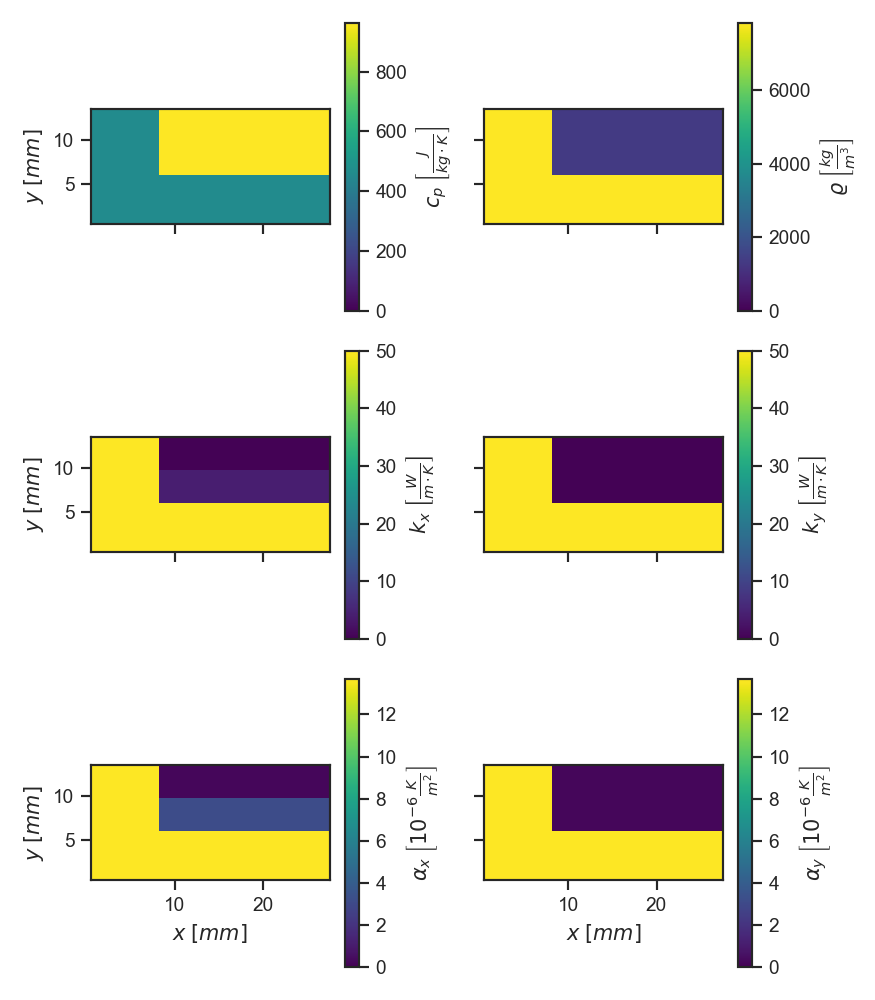

In [33]:
imshow_extent=[x[0]*1000, x[-1]*1000, y[0]*1000, y[-1]*1000]

labels = [r"c_p", r"\varrho", r"k_x", r"k_y", r"\alpha_x", r"\alpha_y"]
units = [r"\frac{J}{kg \cdot K}", r"\frac{kg}{m^3}"]
units += 2* [r"\frac{W}{m \cdot K}"]
units += 2* [r"10^{-6} \frac{K}{m^2}"]

fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=[7, 8])
ax = ax.ravel()
for i, data in enumerate([cp, rho, k_x, k_y, alpha_x*1e6, alpha_y*1e6]):
    plt.sca(ax[i])
    p = plt.imshow(data, cmap="viridis", aspect="equal", vmin=0, origin="lower", 
              extent=imshow_extent)
    label = r"$%s \; \left[ %s \right]$" %(labels[i], units[i])
    plt.colorbar(p, label=label)
[ax[i].set_ylabel(r"$y \; [mm]$") for i in range(0, 6, 2)]
[ax[i].set_xlabel(r"$x \; [mm]$") for i in range(4, 6)]
plt.tight_layout();

## Time discretization

limit for numerical stability: dt = 0.01825125 s
used time step: dt = 1.16808 s
t_max = 6300.0 s = 105.0 min
Nt = 5394


<IPython.core.display.Javascript object>


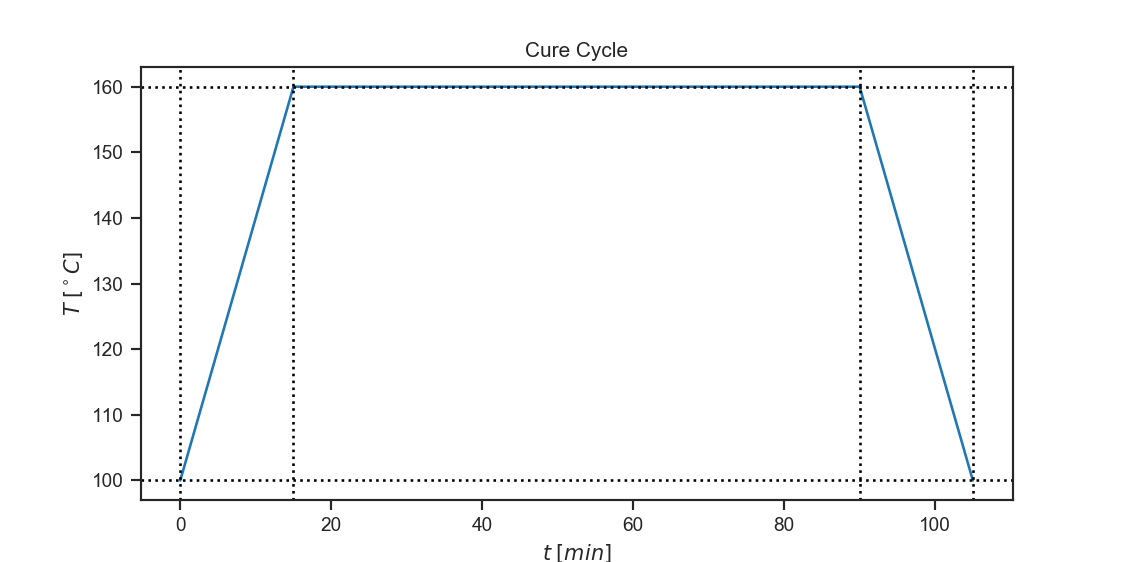

In [34]:
from helpers import add_process_step

# CFL criterion
alpha_max = np.max([np.max(_alpha) for _alpha in [alpha_x, alpha_y]])
dt = dh**2 / alpha_max / 4
print(f"limit for numerical stability: dt = {dt} s")
dt *= 64
print(f"used time step: dt = {dt} s")

## Temperature cycle
# ramp [K/min]
ramp = 4

# start and end temperature [°C]
temp0 = 100
cycle = np.array([[0, temp0]])

# first dwell temperature and dwell duration [min]
temp1 = 160
duration1 = 75
cycle = add_process_step(cycle, temp1, duration1, ramp=ramp)

# second dwell temperature and duration
temp2 = 180
duration2 = 120
#cycle = add_process_step(cycle, temp2, duration2, ramp=ramp)

# cool phase
cycle = add_process_step(cycle, temp0, duration=0, ramp=ramp)

# convert minutes to seconds
cycle[:, 0] *= 60

t_max = cycle[-1, 0]
print(f"t_max = {t_max} s = {t_max / 60} min")
Nt = int(t_max / dt + 1) 
print(f"Nt = {Nt}")
t = np.arange(Nt) * dt


plt.figure()
plt.title('Cure Cycle')
plt.xlabel(r"$t \; [min]$")
plt.ylabel(r"$T \; [ ^\circ C ]$")
plt.plot(cycle[:, 0]/60, cycle[:, 1])
for _temp in np.unique(cycle[:, 1]):
    plt.axhline(_temp, ls=":", color="k")
for _t in np.unique(cycle[:, 0] / 60):
    plt.axvline(_t, ls=":", color="k")    

## Implicit Model and helper funftions

Use the same functions from previous lessons for Crank-Nicholson and Runge-Kutta methods. The latter we have to adapt to the cure calculation. 

In [35]:
def make_indexes(sigma):
    Ny, Nx = np.shape(sigma_x)
    A_size = (Nx - 2) * (Ny - 2)
    
    # matrix indexing -> ravel non-boundary elements from 2d into 1d
    k = np.arange(A_size)
    i = (k % (Nx - 2)) + 1
    j = (k // (Nx - 2)) + 1
    
    left_boundary = i == 1
    right_boundary = i == Nx - 2
    bottom_boundary = j == 1
    top_boundary = j == Ny - 2
    
    return dict(Nx=Nx, Ny=Ny, A_size=A_size, 
                i=i, j=j, k=k,
                left_boundary=left_boundary, 
                right_boundary=right_boundary,               
                bottom_boundary=bottom_boundary, 
                top_boundary=top_boundary
               )

def calc_A_matrices(sigma_x, sigma_y, indexes, Phi=.5):
    """
    Compute Matrices A and A2 for 2D model with dirichlet BC on left and bottom and 
    Neumann BC on right and top side
    """
    
    i = indexes.get("i"); j = indexes.get("j")
    A_size = indexes.get("A_size")
    Nx = indexes.get("Nx"); Ny = indexes.get("Ny")
    left_boundary = indexes.get("left_boundary")
    bottom_boundary = indexes.get("bottom_boundary")
    right_boundary = indexes.get("right_boundary")
    top_boundary = indexes.get("top_boundary")
    
    __temp = sigma_x[j, i + 1] + sigma_x[j, i - 1] + 2 * sigma_x[j, i] + \
             sigma_y[j + 1, i] + sigma_y[j - 1, i] + 2 * sigma_y[j, i]
    A_center_diagonal = Phi * __temp + 2
    A2_center_diagonal = (Phi - 1) * __temp + 2
    
    # No flux bounday conditions on right and top
    __temp = sigma_x[1:-1, -1] + sigma_x[1:-1, -2]
    A_center_diagonal[right_boundary] -= Phi * __temp
    A2_center_diagonal[right_boundary] -= (Phi - 1) * __temp
    __temp = sigma_y[-1, 1:-1] + sigma_y[-2, 1:-1]
    A_center_diagonal[top_boundary] -= Phi * __temp
    A2_center_diagonal[top_boundary] -= (Phi - 1) * __temp
        
    __temp = (sigma_x[j, i - 1] + sigma_x[j, i])[1:]
    __temp[left_boundary[1:]] = 0
    A_left_diagonal_1 = - Phi * __temp
    A2_left_diagonal_1 = (1 - Phi) * __temp

    __temp = (sigma_x[j, i + 1] + sigma_x[j, i])[:-1]
    __temp[right_boundary[:-1]] = 0
    A_right_diagonal_1 = - Phi * __temp
    A2_right_diagonal_1 = (1 - Phi) * __temp

    __temp = (sigma_y[j - 1, i] + sigma_y[j, i])[Nx - 2:]
    __temp[bottom_boundary[Nx - 2:]] = 0
    A_left_diagonal_Nx = - Phi * __temp
    A2_left_diagonal_Nx = (1 - Phi) * __temp

    __temp = (sigma_y[j + 1, i] + sigma_y[j, i])[:-(Nx - 2)]
    __temp[top_boundary[:-(Nx - 2)]] = 0
    A_right_diagonal_Nx = - Phi * __temp
    A2_right_diagonal_Nx = (1 - Phi) * __temp

    A = sparse.diags(diagonals=[A_center_diagonal,
                                A_right_diagonal_1, A_right_diagonal_Nx,
                                A_left_diagonal_1, A_left_diagonal_Nx],
                     offsets=[0, 1, Nx - 2, -1, -Nx + 2],
                     shape=(A_size, A_size),
                     format="csr")

    A2 = sparse.diags(diagonals=[A2_center_diagonal,
                                 A2_right_diagonal_1, A2_right_diagonal_Nx,
                                 A2_left_diagonal_1, A2_left_diagonal_Nx],
                      offsets=[0, 1, Nx - 2, -1, -Nx + 2],
                      shape=(A_size, A_size))
    return A, A2

def calc_b_vector(T, sigma_x, sigma_y, T_left, T_bottom, indexes, Phi=.5):
    """
    Compute vector b_bc for 2D model with dirichlet BC on left and bottom and 
    Neumann BC (no heat flux) on right and top side
    """
    left_boundary = indexes.get("left_boundary")
    bottom_boundary = indexes.get("bottom_boundary")
    
    b = np.zeros(indexes.get("A_size"))
    # Set Dirichlet condition.
    b[left_boundary] += ((1 - Phi) * T[1:-1, 0] + Phi * T_left) * \
                                    (sigma_x[1:-1, 0] + sigma_x[1:-1, 1])
    b[bottom_boundary] += ((1 - Phi) * T[0, 1:-1] + Phi * T_bottom) * \
                                      (sigma_y[0, 1:-1] + sigma_y[1, 1:-1])
    return b

def crank_nicholson_2D(T, sigma_x, sigma_y, A, A2, T_left, T_bottom, indexes, Phi=.5):
    """
    Solve implicit matrix formulation, pass matrices A and A2 
    (only calculate once)
    """
    i = indexes.get("i"); j = indexes.get("j")
    Nx = indexes.get("Nx")
    
    T_1d = np.copy(T[j, i])
    
    b_bc = calc_b_vector(T, sigma_x, sigma_y, T_left, T_bottom, indexes, Phi)
    b = A2.dot(T_1d) + b_bc
    
    T_1d = spsolve(A, b)
    T[1:-1, 1:-1] = T_1d.reshape(-1, Nx - 2)
    
    # set boundary conditions
    T[:, 0] = T_left
    T[0, :] = T_bottom    
    T[:, -1] = T[:, -2]
    T[-1, :] = T[-2, :]

    return T

def RK4_method(X0, dt, temp, cure_model):
    """Runge-Kutta-4-Method for cure model, return reaction rate dX/dT"""
    k1 = cure_calculation.reaction_model(X0, temp, cure_model)
    k2 = cure_calculation.reaction_model(X0 + k1 * dt/2, temp, cure_model)
    k3 = cure_calculation.reaction_model(X0 + k2 * dt/2, temp, cure_model)
    k4 = cure_calculation.reaction_model(X0 + k3 * dt, temp, cure_model)
    dXdt =(k1 + 2*k2 + 2*k3 + k4) / 6
    return dXdt

## Simulate!

i_snap = 35


<IPython.core.display.Javascript object>


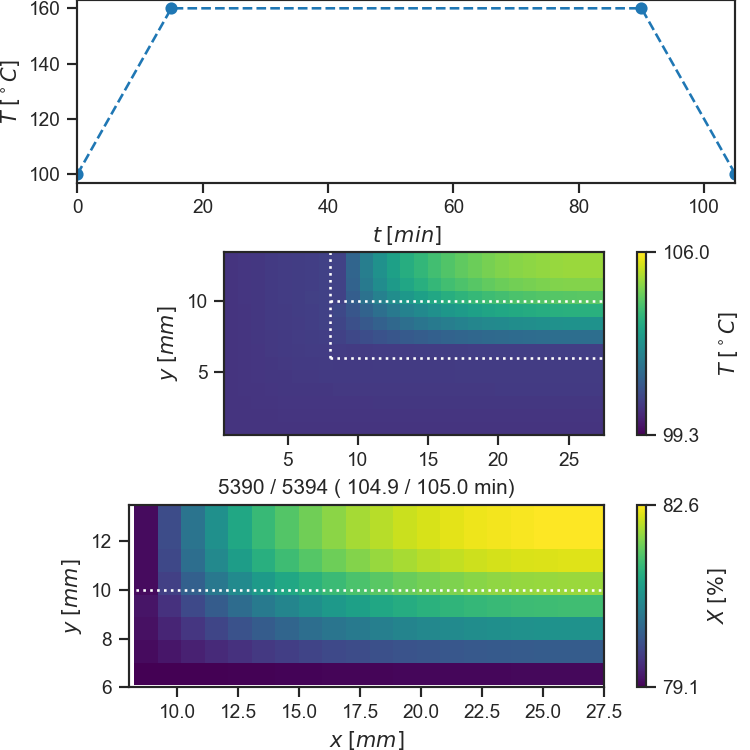

In [36]:
# Set initial conditions
T = np.zeros(shape)
T[:] = cycle[0, 1]

# degree of cure
X = np.zeros(shape)
X[idx_mold] = np.nan

# choose how often to update plot
i_snap = Nt // 150
print("i_snap =", i_snap)

### prepare output arrays
# 1st column: max temp and X in composite
# 2nd column: min temp and X in composite
T_out = np.zeros((Nt, 2))
X_out = np.zeros((Nt, 2))

# prepare plot
fig_sim, ax = plt.subplots(3, 1, figsize=[6, 6])
ax1, ax2, ax3 = ax
line_kw = dict(marker="o", ls="--")
cb_kw = dict(format=FormatStrFormatter('%.1f'))
doc_label=r"$X \; [ \% ]$"

plt.sca(ax1)
plt.xlabel(r"$t \; [min]$")
plt.ylabel(r"$T \; [ ^\circ C ]$")
plt.plot(cycle[:, 0]/60, cycle[:, 1], **line_kw)
p_cycle = plt.axvline(cycle[0, 0]/60, ls=":", color="k")


plt.sca(ax2)
plt.ylabel(r"$T \; [ ^\circ C ]$")
p_temp = plt.imshow(T, cmap="viridis", aspect="equal", origin="lower", 
              extent=imshow_extent)
cb_temp = plt.colorbar(p_temp, label=r"$T \; [ ^\circ C ]$", **cb_kw)

plt.sca(ax3)
plt.ylabel(r"$X \; [ - ]$")
p_cure = plt.imshow(X*100, cmap="viridis", aspect="equal", origin="lower", 
              extent=imshow_extent)
cb_cure = plt.colorbar(p_cure, label=doc_label, **cb_kw)
plt.xlabel(r"$x \; [mm]$")

edge_kw = dict(ls=":", color="w")
for _ax in ax[1:]:
    # plot material domain borders
    _ax.plot([w_mold*1000]*2, [d_mold*1000, y[-1]*1000], **edge_kw)
    _ax.plot([w_mold*1000, x[-1]*1000], [d_mold*1000]*2, **edge_kw)
    _ax.plot([w_mold*1000, x[-1]*1000], [(d_mold + d_ply)*1000]*2, **edge_kw)
    
    _ax.set_ylabel(r"$y \; [mm]$")
    
ax1.autoscale(axis="x", tight=True)

# Show only composite area for degree of cure
ax3.set_xlim([w_mold*1000, None])
ax3.set_ylim([d_mold*1000, None])

plt.tight_layout(pad=0)
plt.ion()
fig_sim.canvas.draw();

In [37]:
Phi = 1 / 2 # Crank-Nicholson-Method
sigma_x = alpha_x * dt / dh**2
sigma_y = alpha_y * dt / dh**2
indexes = make_indexes(sigma_x)
A, A2 = calc_A_matrices(sigma_x, sigma_y, indexes, Phi=.5)

t_heat_model = 0
t_cure_model = 0
for n in range(Nt):
    t0 = time.time()
    # Left Boundary: set value from temperate cycle 
    T_left = cure_calculation.interpol_tempcycle(t[n], cycle)
    T_bottom = T_left
    
    # calculate heat transfer
    T = crank_nicholson_2D(T, sigma_x, sigma_y, A, A2, 
                           T_left, T_bottom, indexes, Phi=.5)
    t_heat_model += time.time() - t0
    
    t0 = time.time()
    # reaction rate
    dXdt = RK4_method(X[idx_comp], dt, T[idx_comp], cure_model)
    # update degree of cure
    X[idx_comp] += dXdt*dt

    # released heat
    q = dXdt * dt * cure_model["Hr"] * (1-composite_material["psi"])    
    T[idx_comp] += q / cp[idx_comp]
    t_cure_model += time.time() - t0    
       
    # write output
    T_out[n, 0] = T[idx_comp].max()
    T_out[n, 1] = T[idx_comp].min()
    X_out[n, 0] = X[idx_comp].max()
    X_out[n, 1] = X[idx_comp].min()
    
    # update plot
    if n % i_snap == 0:
        ax3.set_title(f"{n} / {Nt} ({t[n]/60: .1f} / {t[-1]/60 :.1f} min)")
        p_cycle.set_xdata(t[n]/60)        
        p_temp.set_data(T)
        p_cure.set_data(X*100)    
        
        clim_ext = 1
        clim = np.array([T.min(), T.max()]) + np.array([-clim_ext, clim_ext])
        p_temp.set_clim(clim)
        cb_temp.set_ticks(clim)
        
        clim_ext = 0
        clim = np.array([X[idx_comp].min(), X[idx_comp].max()]) * 100 + np.array([-clim_ext, clim_ext])
        p_cure.set_clim(clim)
        cb_cure.set_ticks(clim)
        fig_sim.canvas.draw()

t_calc = t_heat_model + t_cure_model
print(f"elapsed time for calculation = {t_calc: .3f} s")
print(f"number of iterations = {Nt}")
print(f"-> {Nt / t_calc: .3f} iterations / s")
print(f"Time for heat transfer calculation = {t_heat_model / t_calc * 100 :.2f} %")
print(f"Time for cure reaction calculation = {t_cure_model / t_calc * 100 :.2f} %")

elapsed time for calculation =  9.358 s
number of iterations = 5394
->  576.417 iterations / s
Time for heat transfer calculation = 74.33 %
Time for cure reaction calculation = 25.67 %


## Postprocessing

T_max =  162.942 °C


<IPython.core.display.Javascript object>


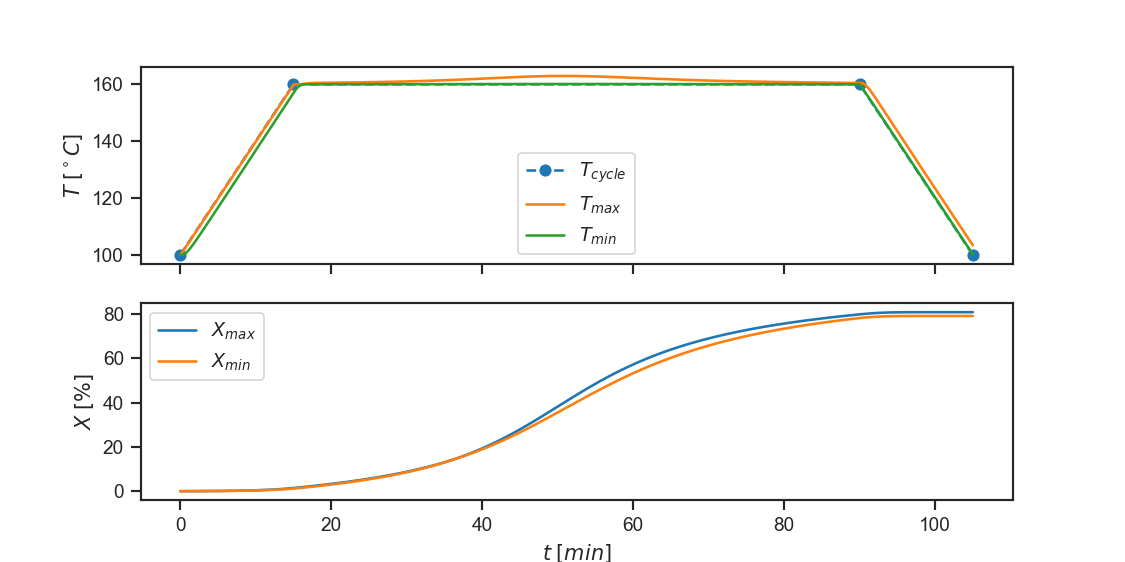

In [29]:
print(f"T_max = {T_out[:, 0].max(): .3f} °C")

fig, ax = plt.subplots(2, 1, sharex=True)
ax1, ax2 = ax
ax1.plot(cycle[:, 0]/60, cycle[:, 1], "o--", label=r"$T_{cycle}$")

for i, _label in enumerate(["max", "min"]):
    plt.sca(ax1)
    label = f"$T_{{{_label}}}$" 
    plt.plot(t/60, T_out[:, i], label=label)
    plt.sca(ax2)
    label = f"$X_{{{_label}}}$" 
    plt.plot(t/60, X_out[:, i]*100, label=label)

for _ax in ax:
    _ax.legend()

ax1.set_ylabel(r"$T \; [ ^\circ C ]$")
ax2.set_ylabel(doc_label)
ax2.set_xlabel(r"$t \; [min]$")

plt.sca(ax3)

plt.tight_layout();

<IPython.core.display.Javascript object>


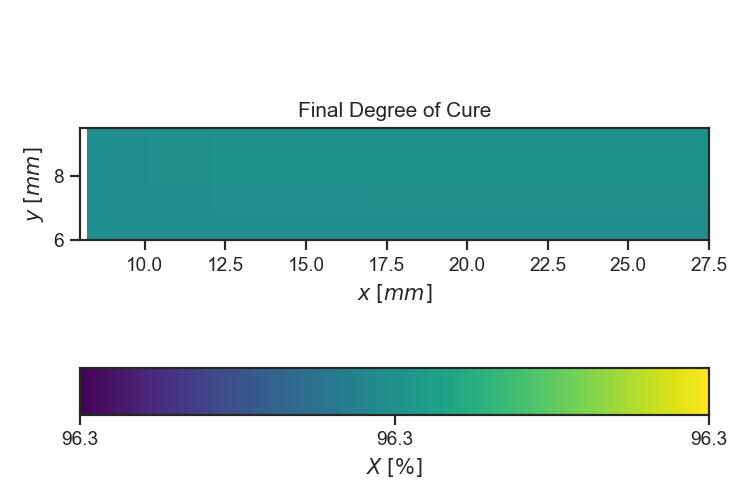

In [11]:
gs = plt.GridSpec(6, 1)

fig = plt.figure(figsize=[6, 4])
ax1 = fig.add_subplot(gs[:-1, :])
plt.title("Final Degree of Cure")

lim_ext = .001
vmin = np.min(X[idx_comp]*100) - lim_ext
vmax = np.max(X[idx_comp]*100) + lim_ext
vmax = min(100, vmax)
p_cure = plt.imshow(X*100, cmap="viridis", aspect="equal", origin="lower", vmin=vmin, vmax=vmax, 
              extent=imshow_extent)
plt.xlim([w_mold*1000, None])
plt.ylim([d_mold*1000, None])
plt.xlabel(r"$x \; [mm]$")    
plt.ylabel(r"$y \; [mm]$")

ax2 = fig.add_subplot(gs[-1, :])
cb_cure = plt.colorbar(p_cure, ax2, label=doc_label, ticks=np.linspace(vmin, vmax, 3),
                      orientation="horizontal", **cb_kw)

plt.tight_layout();

<IPython.core.display.Javascript object>


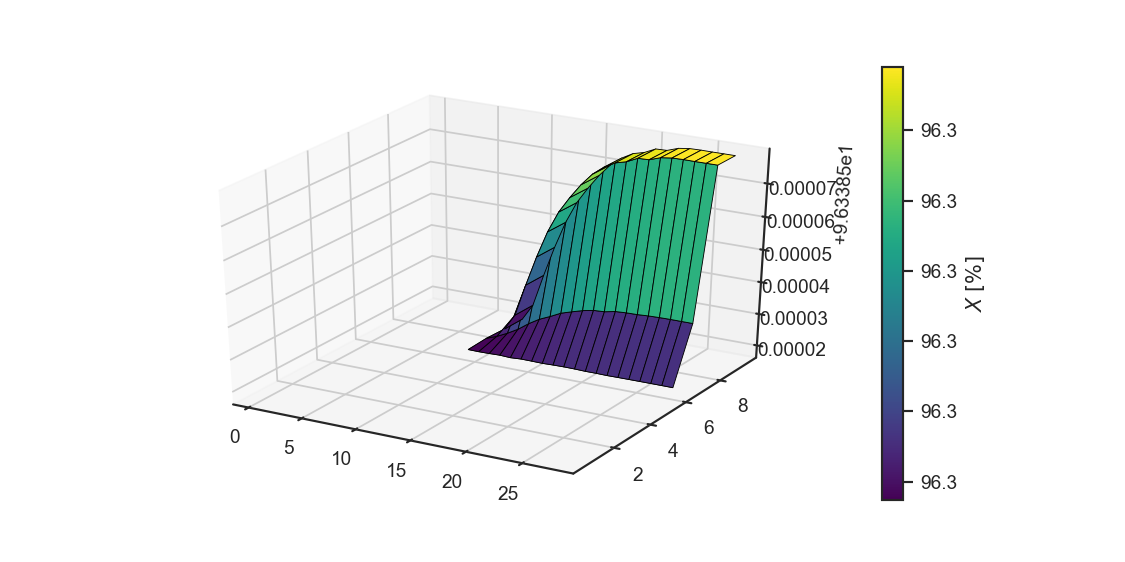

C:\Users\lieb_ni\AppData\Local\Continuum\anaconda3\envs\CureSim\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


In [12]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection="3d")
data = np.copy(X) * 100
data[~idx_comp] = np.nan

lim_ext = 0
vmin = np.nanmin(data) - lim_ext
vmax = np.nanmax(data) + lim_ext
vmax = min(100, vmax)
surf = ax.plot_surface(xx*1000, yy*1000, data, vmin=vmin, vmax=vmax,  
                       linewidth=.5, antialiased=True, cmap="viridis", edgecolor="k")
plt.colorbar(surf, label=doc_label, **cb_kw)